In [1]:
import math
from math import log, sqrt, exp
import numpy as np
import scipy.stats as si
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.integrate import quad

from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.optimize import fmin
from scipy.integrate import quad

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from matplotlib.ticker import PercentFormatter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
import datetime as dt
import warnings

In [2]:
S0 = 100
sigma = 0.2
r = 0.05
maturity = 1/12
K = 100

In [3]:
paths = 50000

In [4]:
N_1 = 21
N_2 = 84

In [5]:
step_size_1 = maturity / N_1
step_size_2 = maturity / N_2

In [6]:
step_size_1

0.003968253968253968

In [7]:
step_size_2

0.000992063492063492

$$dX_t = (r + 0.5\sigma^2)dt + \sigma dW_t$$

For discrete time step, where $t_{i+1}-t_{i} = \Delta t$:
$$X_{t_{i+1}} - X_{t_{i}} = (r + 0.5\sigma^2)\Delta t + \sigma(W_{t_{i+1}} - W_{t_{i}})$$

rearranging, we get

$$X_{t_{i+1}} = X_{t_{i}} + (r + 0.5\sigma^2)\Delta t + \sigma(W_{t_{i+1}} - W_{t_{i}})$$

To get the simulated stock price, we take exponent of the result of $X_t$:
$$S_t = exp(X_t)$$

# Functions

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}


For an option writer who shorts the call option, one needs to hold $\Phi_t$ units of underlying asset $S$ and short $\psi_tB_t$ of cash.<br>

As the value of the option changes by $Delta C_t$, the hedge needs to also update itself by $\phi_t\Delta S_t - r\psi_tB_t\Delta t$.<br>

At the option expiry, the final pnl of the option writer would be:

$$PnL = Premium_{call} + Err_{hedging} - max\{S_T - K, 0\}$$

i.e. The option writer earns the premium collected from selling the call option, plus any gains (or losses) from the imperfect hedge, minus off the difference between the price of the asset and the strike if option expiries in-the-money.

In [8]:
def BlackScholesCall(S0:float, 
                     K:float, 
                     r:float, 
                     sigma:float, 
                     T:float):
    
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    d2 = d1 - sigma*np.sqrt(T)
    
    value = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    return value

In [9]:
# This function calculates the value of the delta of a call option
# It returns the delta of the call option.

def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

In [10]:
# This function calculates the bond position for hedging purposes.
# It returns the bond position needed to hedge the call option.

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

In [11]:
# This function simulates paths of Brownian motion

def simulate_Brownian_Motion(paths,         # Number of simulation paths
                             steps,         # Number of time steps
                             T):            # Total time horizon
    
    # Calculate the time step size 
    deltaT = T/steps
    
    # Generate a time grid t using np.linspace from 0 to T with steps + 1 points.
    t = np.linspace(0, T, steps+1)
    
    # Create a matrix X of random normal increments, with paths rows and steps columns. 
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    
    # Return the time grid t and the cumulative sum of scaled Brownian motion increments to simulate paths of Brownian motion.
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

In [12]:
# This function aims to calculate the profit and loss (PnL) from a hedging strategy over hedging_count time steps, with each step of size step_size.

def hedging_error_calculation(hedging_count,            # Number of hedging steps
                              step_size):               # Size of each time step
    
    # Simulate Brownian motion paths using simulate_Brownian_Motion
    T, W_T = simulate_Brownian_Motion(paths, hedging_count, maturity)
    
    # Simulate the stock price paths using the geometric Brownian motion model.
    blackscholespath = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * W_T)

    # Initializing Error Accumulator
    error_array = 0
    
    # For each step in the hedging process
    for i in range(hedging_count):
        t_px_array = blackscholespath[:, i]             # Stock prices at time T[i]
        tp1_px_array = blackscholespath[:, i+1]         # Stock prices at time T[i+1]
        delta_t = maturity - T[i]                       # Time remaining to maturity at step i.
        
        # Calculate positions in the stock (prev_stock_pos) and bonds (prev_bond_pos) at the current step
        prev_stock_pos = phi(t_px_array, K, r, sigma, delta_t) * t_px_array                 # Value of the stock position in the hedge, calculated using the delta 
        prev_bond_pos = psi_Bt(t_px_array, K, r, sigma, delta_t) * np.exp(r * step_size)    # Value of the bond position in the hedge

        # Update positions at the next time step
        curr_stock_pos = phi(t_px_array, K, r, sigma, delta_t) * tp1_px_array               # New stock position at the next time step.
        curr_bond_pos = psi_Bt(t_px_array, K, r, sigma, delta_t)                            # New bond position at the next time step.

        # Calculate the hedging error tplus1_hedge as the difference between the current and previous hedge positions.
        curr_hedge = curr_stock_pos - curr_bond_pos
        prev_hedge = prev_stock_pos - prev_bond_pos
        tplus1_hedge = curr_hedge - prev_hedge          # Difference between the current and previous hedge positions, representing the change in the hedge position (error).
        
        # Accumulate the hedging errors in error_array.
        error_array += tplus1_hedge    

    # Compute the final profit and loss (pnl) as the accumulated errors plus the difference between the Black-Scholes call value and the option payoff at maturity.
    pnl = error_array + BlackScholesCall(S0, K, r, sigma, maturity) - np.maximum(blackscholespath[:,-1]-K,0)
    
    return pnl

# Start of simulation

In [13]:
np.random.seed(620)

pnl_21 = hedging_error_calculation(N_1, step_size_1)

pnl_84 = hedging_error_calculation(N_2, step_size_2)

hedge_count = [pnl_21, pnl_84]
hedging_steps = [21, 84]

In [14]:
pnl_21

array([ 0.10648663,  0.11095123,  0.17554808, ..., -0.25245413,
       -0.7742949 , -0.23376658])

In [15]:
pnl_84

array([-0.01037168,  0.31077914, -0.23508785, ..., -0.12558455,
       -0.04451659,  0.04524128])

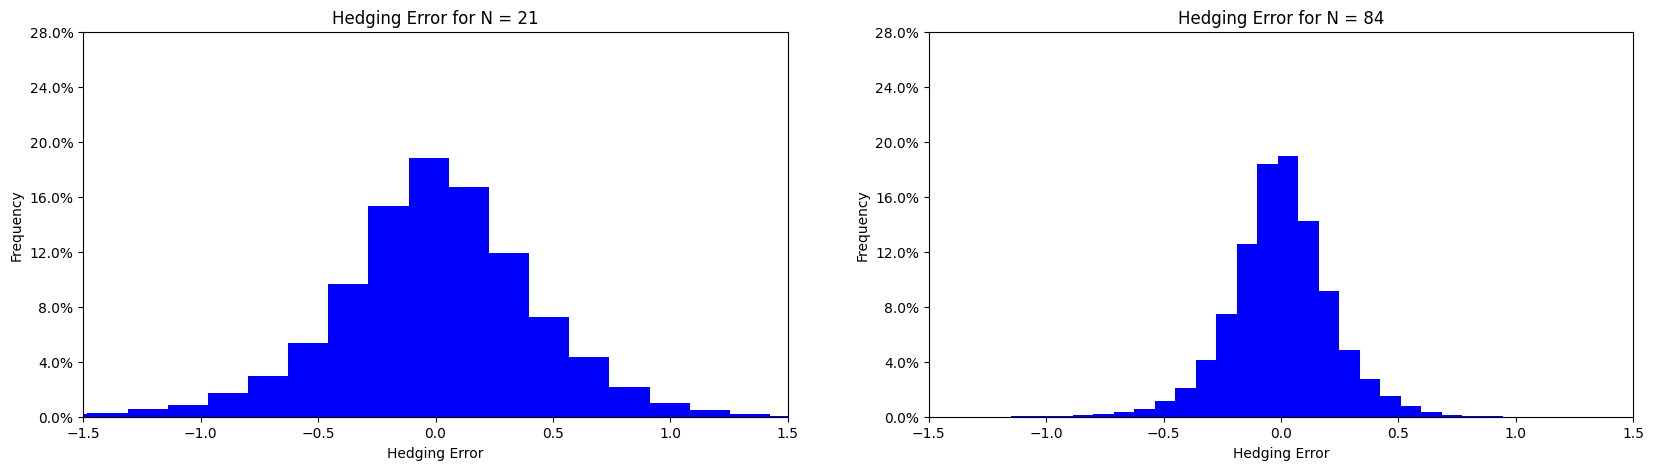

In [16]:
plt.figure(figsize=(20, 5))

for i in range(0, len(hedge_count)):

    plt.subplot(1, 2, i + 1)
    plt.hist(hedge_count[i], 
             weights = np.ones(len(hedge_count[i])) / len(hedge_count[i]), 
             bins = 30, 
             color = 'blue')
    
    plt.title(f'Hedging Error for N = {hedging_steps[i]}')
    plt.xlabel('Hedging Error')
    plt.ylabel('Frequency')
    plt.xlim(-1.5, 1.5)
    plt.yticks(np.arange(0,0.28,0.04))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Format y-axis as percentages
    
plt.show()

Text(0, 0.5, 'Frequency (%)')

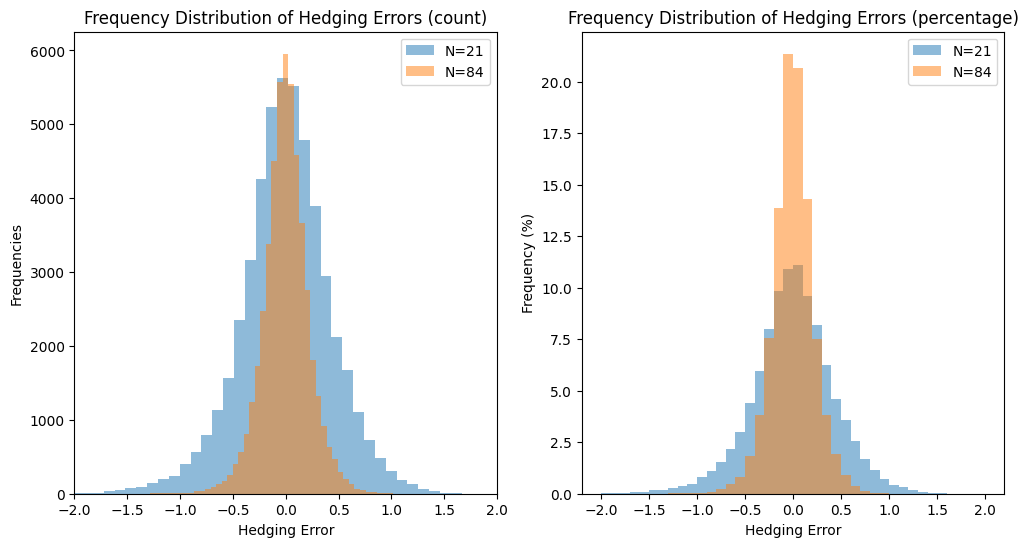

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
for i, hedging_step in enumerate(hedging_steps):
    plt.hist(
        hedge_count[i],
        bins=50,
        align="mid",
        alpha=0.5,
        label=f"N={hedging_step}",
    )
    plt.xlim(-2, 2)
plt.legend()
plt.title("Frequency Distribution of Hedging Errors (count)")
plt.xlabel("Hedging Error")
plt.ylabel("Frequencies")

plt.subplot(122)
for i, hedging_step in enumerate(hedging_steps):
    bins = np.arange(-2.0, 2.1, 0.1)
    counts, edges = np.histogram(hedge_count[i], bins=bins)
    # Convert counts to percentage
    percentages = counts / counts.sum() * 100
    plt.bar(
        edges[:-1],
        percentages,
        width=np.diff(edges),
        align="edge",
        alpha=0.5,
        label=f"N={hedging_step}",
    )

plt.legend()
plt.title("Frequency Distribution of Hedging Errors (percentage)")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency (%)")

In [18]:
# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=(f'Hedging Error for N = {hedging_steps[0]}', f'Hedging Error for N = {hedging_steps[1]}'))

# Add first histogram
fig.add_trace(
    go.Histogram(
        x=hedge_count[0],
        histnorm='probability',  # Normalize to show proportions
        nbinsx=30,
        name=f'Hedging Error for N = {hedging_steps[0]}',
        marker_color='blue'
    ),
    row=1, col=1
)

# Add second histogram
fig.add_trace(
    go.Histogram(
        x=hedge_count[1],
        histnorm='probability',  # Normalize to show proportions
        nbinsx=30,
        name=f'Hedging Error for N = {hedging_steps[1]}',
        marker_color='blue'
    ),
    row=1, col=2
)

# Update layout for titles and formatting
fig.update_layout(
    title="Hedging Error Distributions",
    bargap=0.1,
    showlegend=False,
    template='plotly_white'
)

# Update axis limits and format y-axis as percentages for both subplots
fig.update_xaxes(range=[-1.5, 1.5], row=1, col=1)
fig.update_xaxes(range=[-1.5, 1.5], row=1, col=2)
fig.update_yaxes(tickformat=".0%", row=1, col=1)
fig.update_yaxes(tickformat=".0%", row=1, col=2)

fig.show()

In [19]:
# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Frequency Distribution of Hedging Errors (count)",
                                                    "Frequency Distribution of Hedging Errors (percentage)"))

# Plot the histograms
for i, hedging_step in enumerate(hedging_steps):
    fig.add_trace(
        go.Histogram(
            x=hedge_count[i],
            nbinsx=50,
            name=f"N={hedging_step}",
            opacity=0.5,
        ),
        row=1, col=1
    )

# Plot the bar chart (converted counts to percentages)
for i, hedging_step in enumerate(hedging_steps):
    bins = np.arange(-2.0, 2.1, 0.1)
    counts, edges = np.histogram(hedge_count[i], bins=bins)
    percentages = counts / counts.sum() * 100
    fig.add_trace(
        go.Bar(
            x=edges[:-1],
            y=percentages,
            width=np.diff(edges),
            name=f"N={hedging_step}",
            opacity=0.5
        ),
        row=1, col=2
    )

# Update layout for titles and axis labels
fig.update_layout(
    title_text="Hedging Error Distributions",
    xaxis1_title="Hedging Error",
    yaxis1_title="Frequencies",
    xaxis2_title="Hedging Error",
    yaxis2_title="Frequency (%)",
    bargap=0.1,
    barmode='overlay',
    showlegend=True,
    template='plotly_white'
)

fig.show()

In [20]:
print('Hedging 21 Times:')
print(f'Mean error: {round(pnl_21.mean(),5)}\nStandard Deviation: {round(pnl_21.std(), 2)}\nStd of PnL as a % of Option Premium: {round(100 * pnl_21.std() / BlackScholesCall(S0, K, r, sigma, maturity), 1)}%')
print()
print('Hedging 84 Times:')
print(f'Mean error: {round(pnl_84.mean(),5)}\nStandard Deviation: {round(pnl_84.std(), 2)}\nStd of PnL as a % of Option Premium: {round(100 * pnl_84.std() / BlackScholesCall(S0, K, r, sigma, maturity), 1)}%')

Hedging 21 Times:
Mean error: -0.0026
Standard Deviation: 0.43
Std of PnL as a % of Option Premium: 17.1%

Hedging 84 Times:
Mean error: -0.00125
Standard Deviation: 0.22
Std of PnL as a % of Option Premium: 8.6%
